## Data Preprocessing

In [14]:
import pandas
import matplotlib.pyplot as plt

In [15]:
df = pandas.read_csv("HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [16]:
df.dropna(inplace=True)
df.shape

(9958, 7)

<Axes: xlabel='dx'>

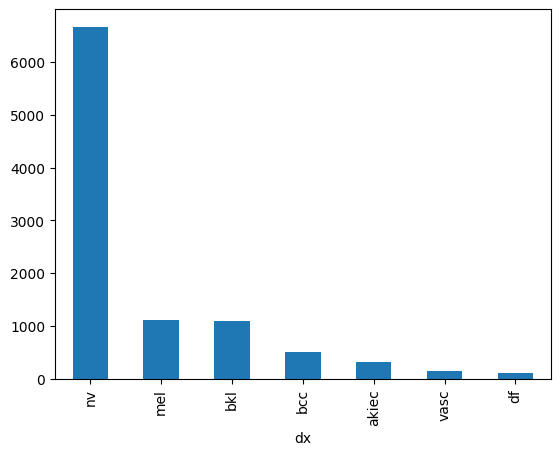

In [17]:
target_counts = df["dx"].value_counts()
target_counts.plot(kind="bar")

In [18]:
keys = df["dx"].unique()
keys

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [19]:
index_dict = {item: index for index, item in enumerate(keys)}
print(index_dict)
df["target_id"] = df["dx"].map(lambda x: index_dict[x])
df.sample(10)

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


,lesion_id,image_id,dx,dx_type,age,sex,localization,target_id
1507,HAM_0002824,ISIC_0033047,mel,histo,25.0,female,lower extremity,3
6039,HAM_0003166,ISIC_0030848,nv,follow_up,50.0,female,foot,1
3217,HAM_0002465,ISIC_0026565,nv,follow_up,40.0,female,trunk,1
4458,HAM_0006508,ISIC_0030342,nv,follow_up,50.0,female,foot,1
3298,HAM_0007204,ISIC_0025205,nv,follow_up,45.0,female,lower extremity,1
6060,HAM_0005118,ISIC_0025357,nv,follow_up,35.0,female,abdomen,1
5463,HAM_0007564,ISIC_0028119,nv,follow_up,45.0,male,lower extremity,1
6816,HAM_0003767,ISIC_0027358,nv,histo,60.0,male,upper extremity,1
8824,HAM_0000603,ISIC_0030742,nv,histo,80.0,male,abdomen,1
5127,HAM_0001797,ISIC_0031155,nv,follow_up,45.0,female,abdomen,1


## Training

In [20]:
import random
SEED = 1234
random.seed(SEED)

test_ratio = 0.2

def train_test_split(df, test_size=0.2, random_state=None):
    test_df = df.sample(frac=test_size, random_state=random_state)
    train_df = df.drop(test_df.index)
    return train_df, test_df

train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=SEED)
train_df.shape, test_df.shape

((7966, 8), (1992, 8))

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

torch.manual_seed(SEED)


In [22]:
BASE_PATH = "data"
FILE_TEMPLATE = "{}.jpg"

class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, transform=None):
        
        if len(image_ids) != len(labels):
            raise ValueError(f"Value mismatch between images ({len(image_ids)}) and labels ({len(labels)})")
        
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = float(self.labels[idx])
        img_path = os.path.join(BASE_PATH, FILE_TEMPLATE.format(image_id))
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

train_dataset = ImageDataset(train_df["image_id"].to_list(), train_df["target_id"].to_list())
test_dataset = ImageDataset(test_df["image_id"].to_list(), test_df["target_id"].to_list())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
class DermaScannerModel(nn.Module):
    def __init__(self, num_classes=7):
        super(DermaScannerModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),  # (64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (32, 32)
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2), # (32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (16, 16)
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2), # (16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (8, 8)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),              # -> 64 * 8 * 8 = 4096
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [24]:
EPOCH = 15

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DermaScannerModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(EPOCH):
    model.train()
    train_loss = 0
    train_total = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batch_size = images.size(0)
        train_loss += loss.item()
        train_total += batch_size

    model.eval()
    eval_loss = 0
    eval_total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Eval"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.long())

            batch_size = images.size(0)
            eval_loss += loss.item()
            eval_total += batch_size

    avg_train_loss = train_loss / train_total
    avg_eval_loss = eval_loss / eval_total

    print(f"EPOCH: {epoch}\tEval Loss: {avg_eval_loss:.4f}\tTrain Loss: {avg_train_loss:.4f}")


Eval: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


EPOCH: 0	Eval Loss: 0.0314	Train Loss: 0.0328


Eval: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


EPOCH: 1	Eval Loss: 0.0300	Train Loss: 0.0295


Eval: 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]


EPOCH: 2	Eval Loss: 0.0281	Train Loss: 0.0279


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.24it/s]


EPOCH: 3	Eval Loss: 0.0290	Train Loss: 0.0266


Eval: 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


EPOCH: 4	Eval Loss: 0.0258	Train Loss: 0.0257


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


EPOCH: 5	Eval Loss: 0.0263	Train Loss: 0.0246


Eval: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]


EPOCH: 6	Eval Loss: 0.0249	Train Loss: 0.0238


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]


EPOCH: 7	Eval Loss: 0.0242	Train Loss: 0.0228


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.19it/s]


EPOCH: 8	Eval Loss: 0.0237	Train Loss: 0.0220


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]


EPOCH: 9	Eval Loss: 0.0251	Train Loss: 0.0212


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


EPOCH: 10	Eval Loss: 0.0241	Train Loss: 0.0208


Eval: 100%|██████████| 63/63 [00:14<00:00,  4.31it/s]


EPOCH: 11	Eval Loss: 0.0228	Train Loss: 0.0204


Eval: 100%|██████████| 63/63 [00:13<00:00,  4.53it/s]


EPOCH: 12	Eval Loss: 0.0237	Train Loss: 0.0192


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]


EPOCH: 13	Eval Loss: 0.0229	Train Loss: 0.0186


Eval: 100%|██████████| 63/63 [00:13<00:00,  4.77it/s]

EPOCH: 14	Eval Loss: 0.0235	Train Loss: 0.0177


In [25]:
from sklearn.metrics import classification_report
total_output = []
total_targets = []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_output.extend(predicted.numpy())
        total_targets.extend(labels.numpy())

result = classification_report(total_targets, total_output, target_names=keys)
print(result)

              precision    recall  f1-score   support

         bkl       0.54      0.40      0.46       225
          nv       0.81      0.95      0.87      1312
          df       0.50      0.10      0.16        31
         mel       0.54      0.33      0.41       241
        vasc       0.76      0.59      0.67        32
         bcc       0.54      0.38      0.45        97
       akiec       0.36      0.37      0.37        54

    accuracy                           0.75      1992
   macro avg       0.58      0.45      0.48      1992
weighted avg       0.72      0.75      0.72      1992


## Saving Model

In [26]:
save_path = "../backend/cnn_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"File save successful: {os.path.exists(save_path)}")

File save successful: True
